In [ ]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [1]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [2]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-11 18:09:14--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-11 18:09:14--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   251MB/s    in 0.2s    

2025-05-11 18:09:15 (251 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [48]:
# Cargar la imagen original
img = cv2.imread("hp_niños.jpg")

if img is None:
  print("Error al cargar la imagen 'Santi1.jpg'. Verifica la ruta.")
else:
  print("Imagen original cargada (formato BGR). Dimensiones:", img.shape)

Imagen original cargada (formato BGR). Dimensiones: (1440, 2560, 3)


## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

In [49]:
#Utilizamos la funcion cvtColor de la libreria cv2 para transformar el esquema de color
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Imagen RGB convertida. Dimensiones:", img_rgb.shape)

Imagen RGB convertida. Dimensiones: (1440, 2560, 3)


Text(0.5, 1.0, 'Imagen Original')

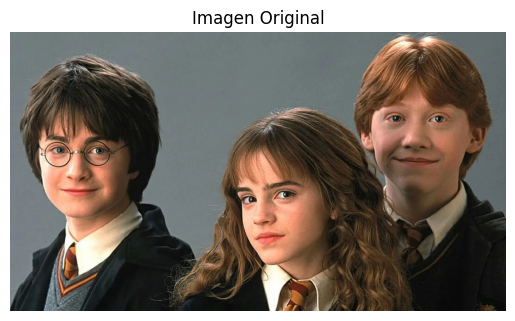

In [50]:
#utilizamod matplotlib para mostrar la imagen en transformada a rgb
plt.imshow(img_rgb)
plt.gca().set_axis_off() #quito ejes
plt.title("Imagen Original")

### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

In [51]:
#transformo la imagen elegida a escala de grises)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Imagen gris convertida. Dimensiones:", img_gris.shape)

Imagen gris convertida. Dimensiones: (1440, 2560)


Text(0.5, 1.0, 'Imagen Escala Grises')

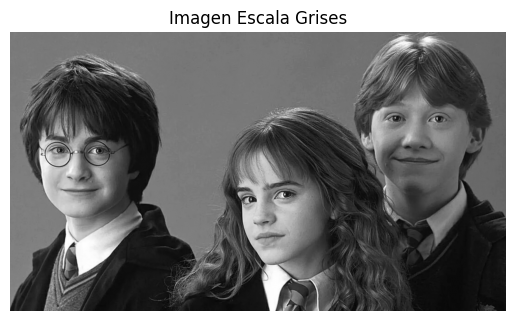

In [52]:
plt.imshow(img_gris, cmap='gray')
plt.gca().set_axis_off()
plt.title("Imagen Escala Grises")

### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

In [54]:
# Creamos el clasificador utilizando haarcascade
clasi_rostro = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

if clasi_rostro.empty():
    print("Error cargando el clasificador Haar. Verifica el archivo 'haarcascade_frontalface_default.xml'.")
else:
    print("Clasificador Haar cargado.")

# Aplicamos el metodo detectMultiScale del clasificador
# Ingresamos distintos parametros para afinar la deteccion: por ejemplo minNeighbors, minSize
    rostros = clasi_rostro.detectMultiScale(img_gris,
                                          scaleFactor=1.1,
                                          minNeighbors=7,
                                          minSize=(30, 30),
                                          flags=cv2.CASCADE_SCALE_IMAGE)

    print(f"Se encontraron {len(rostros)} rostros.")
    # rostros es un array de numpy, donde cada fila es [x, y, width, height]
    print("Rostros detectados (formato [x, y, ancho, alto]):")
    print(rostros)

Clasificador Haar cargado.
Se encontraron 3 rostros.
Rostros detectados (formato [x, y, ancho, alto]):
[[1791  228  588  588]
 [  88  413  527  527]
 [1084  670  470  470]]


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

Dibujando rectángulos en la imagen gris...


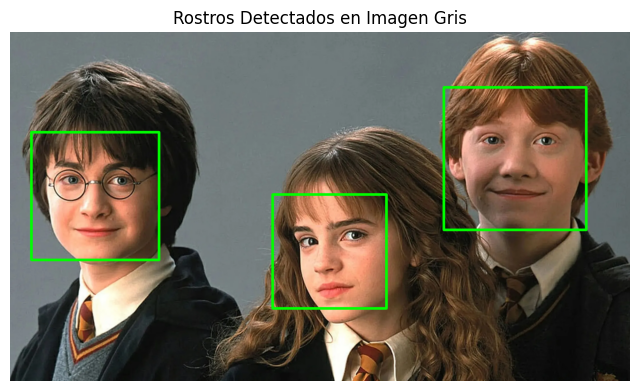

In [55]:
# Definimos color del rectangulo
color_rectangulo = (0,255,0) # Blanco

# Dibujar rectángulo sobre la imagen a partir de coordenadas obtenidas en "rostros"
if len(rostros) > 0:
    print("Dibujando rectángulos en la imagen gris...")
    for (x, y, w, h) in rostros:
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), color_rectangulo, 10) # Grosor de línea 2

    # Mostrar la imagen con el rectángulo
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title("Rostros Detectados en Imagen Gris")
    plt.gca().set_axis_off()
    plt.show()
else:
    print("No se detectaron rostros para dibujar.")

## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [56]:
# Cargar el detector de landmarks y aplicarlo

if img_gris is not None and len(rostros) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(img_gris, rostros)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('rostros').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 3 rostro(s).


### 2.2 Procesar y Visualizar Landmarks (Pauls)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Pauls) y los dibujamos.

Landmarks Ron procesados. Forma: (68, 2)

Dibujando landmarks de Ron (verde):

Zoom en Ron:


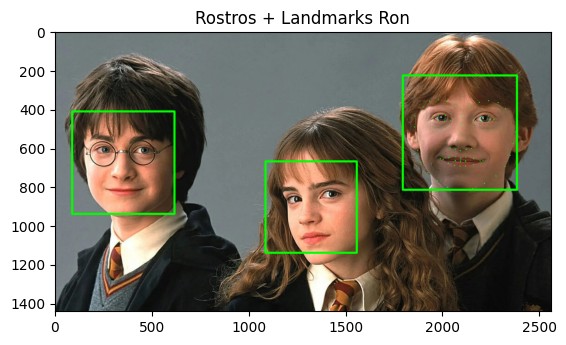

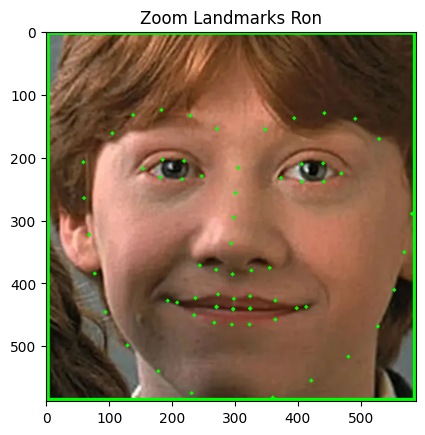

In [60]:
# Procesar y dibujar landmarks de Ron

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_ron = all_landmarks[0] #rostro de Ron
  # Quitar dimensión extra y convertir a enteros
  landmarks_ron = landmarks_ron[0].astype(int)
  print("Landmarks Ron procesados. Forma:", landmarks_ron.shape)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Ron (verde):")
  for x, y in landmarks_ron:
      cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), 3) # Radio 0, grosor 1 para punto pequeño
  plt.imshow(img_rgb)
  plt.title("Rostros + Landmarks Ron")

  # Mostrar zoom
  print("\nZoom en Ron:")
  plt.figure()
  plt.imshow(img_rgb[228:816 , 1791:2379])
  plt.title("Zoom Landmarks Ron")

else:
  print("No hay landmarks disponibles para procesar.")

### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (Harry)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

Landmarks Harry procesados. Forma: (68, 2)

Dibujando landmarks de Harry (rojo):

Zoom en Harry:


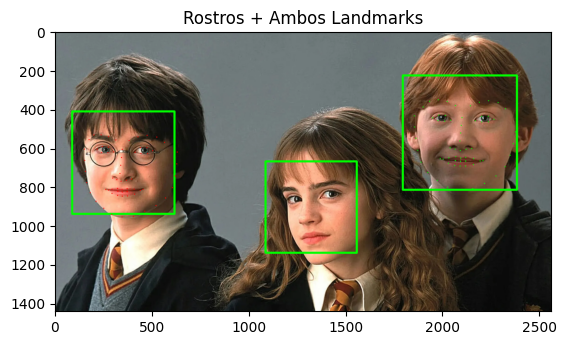

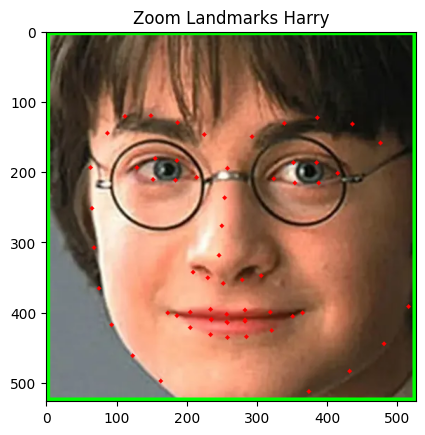

In [69]:
# Solución Ejercicio 5 (Procesar y dibujar landmarks Harry)

if all_landmarks is not None and len(all_landmarks) >= 3:
  # Procesar landmarks Harry (indice 1)
  landmarks_harry = all_landmarks[1]
  landmarks_harry = landmarks_harry[0].astype(int)
  print("Landmarks Harry procesados. Forma:", landmarks_harry.shape)

  # Dibujar sobre la imagen 'img_rgb' existente
  print("\nDibujando landmarks de Harry (rojo):")
  for x, y in landmarks_harry:
      cv2.circle(img_rgb, (x, y), 1, (255, 0, 0), 3)
  plt.imshow(img_rgb)
  plt.title("Rostros + Ambos Landmarks")

  # Mostrar zoom
  print("\nZoom en Harry:")
  plt.figure()
  plt.imshow(img_rgb[413:940, 88:615])
  plt.title("Zoom Landmarks Harry")

elif all_landmarks is None:
  print("No hay landmarks disponibles.")
elif len(all_landmarks) < 2:
  print("Solo se detectó 1 rostro, no se pueden procesar landmarks para Harry.")

## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Pauls)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_pauls`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

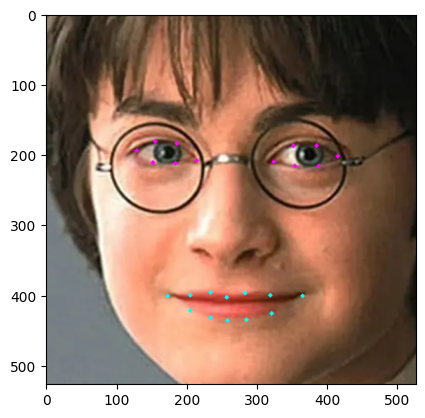

In [73]:
img_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ojos_indices = list(range(36,42)) + list(range(42,48))
boca_indices = list(range(48,60))

for i, (x, y) in enumerate(landmarks_harry):
  if i in ojos_indices:
    color = (255, 0, 255)
  elif i in boca_indices:
    color = (0, 255, 255)
  else:
    continue

  cv2.circle(img_partes, (x,y), 1, color, 3)

#x, y, w, h = harry
plt.figure()
zoom = img_partes[413:940, 88:615]
plt.imshow(zoom)

## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.